In [95]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, Bidirectional, Dropout, GlobalMaxPool1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model

In [96]:
train_data = pd.read_excel("data_split_latest/train.xlsx")
test_data = pd.read_excel("data_split_latest/test.xlsx")

X_train = train_data['stemmed_full_text'].astype(str).tolist()
y_train = np.array(train_data['encoded_label'].tolist()).astype(int)

X_test = test_data['stemmed_full_text'].astype(str).tolist()
y_test = np.array(test_data['encoded_label'].tolist()).astype(int)

In [97]:
# Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = X_train_resampled.ravel()

In [98]:
# Padding
MAX_WORDS, MAX_LEN, EMBEDDING_DIM = 5000, 30, 50
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_resampled)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train_resampled), maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, padding='post')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model Bi-LSTM Dibuat
Model Bi-GRU Dibuat
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Evaluasi Bi-LSTM:
              precision    recall  f1-score   support

     Negatif     0.9796    0.8571    0.9143        56
     Positif     0.9651    0.9955    0.9800       222

    accuracy                         0.9676       278
   macro avg     0.9723    0.9263    0.9472       278
weighted avg     0.9680    0.9676    0.9668       278

Evaluasi Bi-GRU:
              precision    recall  f1-score   support

     Negatif     0.9800    0.8750    0.9245        56
     Positif     0.9693    0.9955    0.9822       222

    accuracy                         0.9712       278
   macro avg     0.9746    0.9352    0.9534       278
weighted avg     0.9715    0.9712    0.9706       278



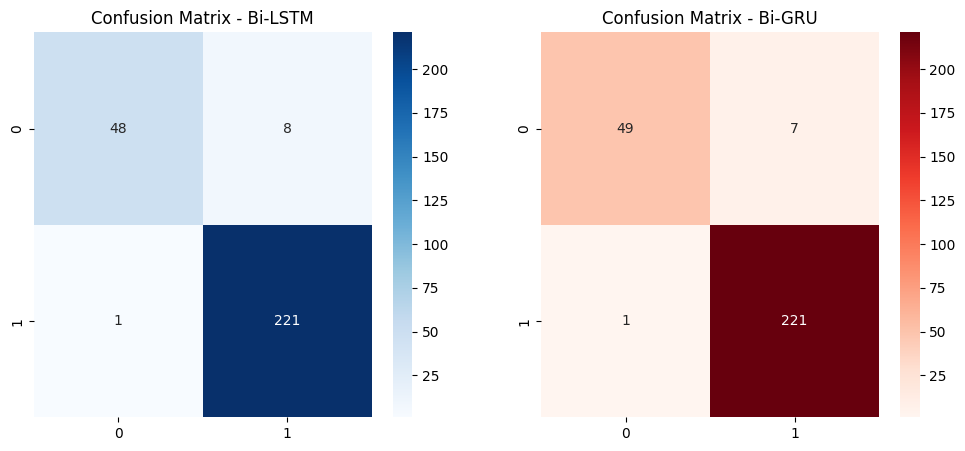

In [99]:
# Model Bi-LSTM
model_bilstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model_bilstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("Model Bi-LSTM Dibuat")

history_bilstm = model_bilstm.fit(X_train_pad, y_train_resampled, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32, verbose=0)

# Model Bi-GRU
model_bigru = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(GRU(32)),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model_bigru.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("Model Bi-GRU Dibuat")

history_bigru = model_bigru.fit(X_train_pad, y_train_resampled, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32, verbose=0)

# Evaluasi Model
y_pred_bilstm = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
y_pred_bigru = (model_bigru.predict(X_test_pad) > 0.5).astype("int32").flatten()

print("Evaluasi Bi-LSTM:")
print(classification_report(y_test, y_pred_bilstm, target_names=["Negatif", "Positif"], digits=4))
print("Evaluasi Bi-GRU:")
print(classification_report(y_test, y_pred_bigru, target_names=["Negatif", "Positif"], digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Bi-LSTM")
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_bigru), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Bi-GRU")
plt.show()

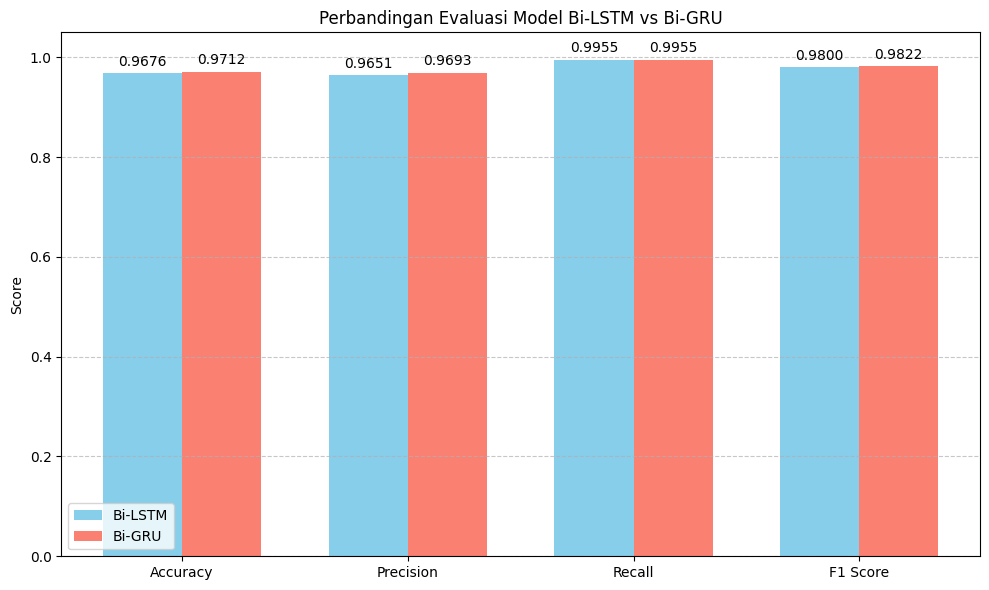

In [100]:
# Hitung metrik untuk Bi-LSTM
acc_bilstm = accuracy_score(y_test, y_pred_bilstm)
prec_bilstm = precision_score(y_test, y_pred_bilstm, average='binary')
rec_bilstm = recall_score(y_test, y_pred_bilstm, average='binary')
f1_bilstm = f1_score(y_test, y_pred_bilstm, average='binary')

# Hitung metrik untuk Bi-GRU
acc_bigru = accuracy_score(y_test, y_pred_bigru)
prec_bigru = precision_score(y_test, y_pred_bigru, average='binary')
rec_bigru = recall_score(y_test, y_pred_bigru, average='binary')
f1_bigru = f1_score(y_test, y_pred_bigru, average='binary')

# Simpan skor
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bilstm_scores = [acc_bilstm, prec_bilstm, rec_bilstm, f1_bilstm]
bigru_scores = [acc_bigru, prec_bigru, rec_bigru, f1_bigru]

# Plot bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, bilstm_scores, width, label='Bi-LSTM', color='skyblue')
bars2 = ax.bar(x + width/2, bigru_scores, width, label='Bi-GRU', color='salmon')

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score')
ax.set_ylim(0, 1.05)
ax.set_title('Perbandingan Evaluasi Model Bi-LSTM vs Bi-GRU')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [101]:
# Pengujian dropout
dropout_rates = [0.2, 0.3, 0.5]
bilstm_results_dropout = []

# Uji dropout untuk Bi-LSTM
for rate in dropout_rates:
    print(f"\n=== Bi-LSTM Dropout {rate} ===")
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(32)),
        Dropout(rate),
        Dense(1, activation='sigmoid')
    ])
    model_bilstm.compile(loss='binary_crossentropy',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['accuracy'])

    history = model_bilstm.fit(X_train_pad, y_train_resampled,
                              epochs=10,
                              validation_data=(X_test_pad, y_test),
                              batch_size=32,
                              verbose=0)

    y_pred = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)

    bilstm_results_dropout.append((rate, acc))
    print(f"Akurasi Bi-LSTM dengan Dropout {rate}: {acc:.4f}")

# Tentukan dropout terbaik
best_dropout, best_acc_dropout = max(bilstm_results_dropout, key=lambda x: x[1])

print("\n=== Hasil Akhir ===")
print(f"Dropout Terbaik untuk Bi-LSTM : {best_dropout} dengan Akurasi: {best_acc_dropout:.4f}")


=== Bi-LSTM Dropout 0.2 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Akurasi Bi-LSTM dengan Dropout 0.2: 0.9748

=== Bi-LSTM Dropout 0.3 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Akurasi Bi-LSTM dengan Dropout 0.3: 0.9676

=== Bi-LSTM Dropout 0.5 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Akurasi Bi-LSTM dengan Dropout 0.5: 0.9676

=== Hasil Akhir ===
Dropout Terbaik untuk Bi-LSTM : 0.2 dengan Akurasi: 0.9748


In [102]:
# Pengujian optimizer
optimizer_names = ['SGD', 'Adam', 'Adadelta', 'RMSprop']
bilstm_results_optimizer = []

def get_optimizer(name, learning_rate=0.001):
    if name == 'SGD':
        return SGD(learning_rate=learning_rate)
    elif name == 'Adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'Adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif name == 'RMSprop':
        return RMSprop(learning_rate=learning_rate)

# Uji optimizer untuk Bi-LSTM
for name in optimizer_names:
    print(f"\n=== Bi-LSTM Optimizer {name} ===")
    opt = get_optimizer(name)

    model_bilstm = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(32)),
        Dropout(best_dropout),
        Dense(1, activation='sigmoid')
    ])
    model_bilstm.compile(loss='binary_crossentropy',
                        optimizer=opt,
                        metrics=['accuracy'])
    
    history = model_bilstm.fit(X_train_pad, y_train_resampled,
                              epochs=10,
                              validation_data=(X_test_pad, y_test),
                              batch_size=32,
                              verbose=0)
    
    y_pred = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)
    
    bilstm_results_optimizer.append((name, acc))
    print(f"Akurasi Bi-LSTM dengan Optimizer {name}: {acc:.4f}")

# Menentukan optimizer terbaik
best_optimizer, best_acc_optimizer = max(bilstm_results_optimizer, key=lambda x: x[1])

print("\n=== Hasil Akhir ===")
print(f"Optimizer Terbaik untuk Bi-LSTM : {best_optimizer} dengan Akurasi: {best_acc_optimizer:.4f}")


=== Bi-LSTM Optimizer SGD ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Akurasi Bi-LSTM dengan Optimizer SGD: 0.7806

=== Bi-LSTM Optimizer Adam ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Akurasi Bi-LSTM dengan Optimizer Adam: 0.9640

=== Bi-LSTM Optimizer Adadelta ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Akurasi Bi-LSTM dengan Optimizer Adadelta: 0.7914

=== Bi-LSTM Optimizer RMSprop ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Akurasi Bi-LSTM dengan Optimizer RMSprop: 0.9568

=== Hasil Akhir ===
Optimizer Terbaik untuk Bi-LSTM : Adam dengan Akurasi: 0.9640


In [103]:
# Pengujian batch size
batch_sizes = [24, 32, 64, 128]
bilstm_results_batch = []

# Uji batch size untuk Bi-LSTM
for batch in batch_sizes:
    print(f"\n=== Bi-LSTM Batch Size {batch} ===")
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(32)),
        Dropout(best_dropout),
        Dense(1, activation='sigmoid')
    ])
    model_bilstm.compile(loss='binary_crossentropy',
                        optimizer=get_optimizer(best_optimizer, learning_rate=0.001),
                        metrics=['accuracy'])
    
    model_bilstm.fit(X_train_pad, y_train_resampled,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    batch_size=batch,
                    verbose=0)
    
    y_pred = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)
    
    bilstm_results_batch.append((batch, acc))
    print(f"Akurasi Bi-LSTM dengan Batch Size {batch}: {acc:.4f}")

# Menentukan batch size terbaik
best_batch, best_acc_batch = max(bilstm_results_batch, key=lambda x: x[1])

print("\n=== Hasil Uji Batch Size ===")
print(f"Batch Size Terbaik untuk Bi-LSTM : {best_batch} dengan Akurasi: {best_acc_batch:.4f}")



=== Bi-LSTM Batch Size 24 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Akurasi Bi-LSTM dengan Batch Size 24: 0.9676

=== Bi-LSTM Batch Size 32 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Akurasi Bi-LSTM dengan Batch Size 32: 0.9712

=== Bi-LSTM Batch Size 64 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Akurasi Bi-LSTM dengan Batch Size 64: 0.9676

=== Bi-LSTM Batch Size 128 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Akurasi Bi-LSTM dengan Batch Size 128: 0.9712

=== Hasil Uji Batch Size ===
Batch Size Terbaik untuk Bi-LSTM : 32 dengan Akurasi: 0.9712


In [104]:
# Pengujian unit
unit_sizes = [32, 64, 128, 256]
bilstm_results_unit = []

# Uji jumlah unit untuk Bi-LSTM
for units in unit_sizes:
    print(f"\n=== Bi-LSTM Units {units} ===")
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(units)),
        Dropout(best_dropout),
        Dense(1, activation='sigmoid')
    ])
    model_bilstm.compile(loss='binary_crossentropy',
                        optimizer=get_optimizer(best_optimizer, learning_rate=0.001),
                        metrics=['accuracy'])
    
    model_bilstm.fit(X_train_pad, y_train_resampled,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    batch_size=best_batch,
                    verbose=0)
    
    y_pred = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)
    
    bilstm_results_unit.append((units, acc))
    print(f"Akurasi Bi-LSTM dengan {units} units: {acc:.4f}")

# Menentukan unit terbaik
best_unit, best_acc_unit = max(bilstm_results_unit, key=lambda x: x[1])

print("\n=== Hasil Uji Jumlah Units ===")
print(f"Jumlah Unit Terbaik untuk Bi-LSTM : {best_unit} dengan Akurasi: {best_acc_unit:.4f}")



=== Bi-LSTM Units 32 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Akurasi Bi-LSTM dengan 32 units: 0.9676

=== Bi-LSTM Units 64 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Akurasi Bi-LSTM dengan 64 units: 0.9496

=== Bi-LSTM Units 128 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Akurasi Bi-LSTM dengan 128 units: 0.9496

=== Bi-LSTM Units 256 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Akurasi Bi-LSTM dengan 256 units: 0.9353

=== Hasil Uji Jumlah Units ===
Jumlah Unit Terbaik untuk Bi-LSTM : 32 dengan Akurasi: 0.9676


In [105]:
# Pengujian learning rate
learning_rates = [0.1, 0.005, 0.025, 0.001]
bilstm_results_lr = []

# Uji learning rate untuk Bi-LSTM
for lr in learning_rates:
    print(f"\n=== Bi-LSTM Learning Rate {lr} ===")
    model_bilstm = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(LSTM(best_unit)),
        Dropout(best_dropout),
        Dense(1, activation='sigmoid')
    ])
    model_bilstm.compile(loss='binary_crossentropy',
                        optimizer=get_optimizer(best_optimizer, learning_rate=lr),
                        metrics=['accuracy'])
    
    model_bilstm.fit(X_train_pad, y_train_resampled,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    batch_size=best_batch,
                    verbose=0)
    
    y_pred = (model_bilstm.predict(X_test_pad) > 0.5).astype("int32").flatten()
    acc = accuracy_score(y_test, y_pred)
    
    bilstm_results_lr.append((lr, acc))
    print(f"Akurasi Bi-LSTM dengan learning rate {lr}: {acc:.4f}")

# Menentukan learning rate terbaik
best_lr, best_acc_lr = max(bilstm_results_lr, key=lambda x: x[1])

print("\n=== Hasil Uji Learning Rate ===")
print(f"Learning Rate Terbaik untuk Bi-LSTM : {best_lr} dengan Akurasi: {best_acc_lr:.4f}")



=== Bi-LSTM Learning Rate 0.1 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Akurasi Bi-LSTM dengan learning rate 0.1: 0.9137

=== Bi-LSTM Learning Rate 0.005 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Akurasi Bi-LSTM dengan learning rate 0.005: 0.9604

=== Bi-LSTM Learning Rate 0.025 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Akurasi Bi-LSTM dengan learning rate 0.025: 0.9604

=== Bi-LSTM Learning Rate 0.001 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Akurasi Bi-LSTM dengan learning rate 0.001: 0.9532

=== Hasil Uji Learning Rate ===
Learning Rate Terbaik untuk Bi-LSTM : 0.005 dengan Akurasi: 0.9604


Model Bi-LSTM Dibuat

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model Bi-GRU Dibuat
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Evaluasi Bi-LSTM:
              precision    recall  f1-score   support

           0     0.9811    0.9286    0.9541        56
           1     0.9822    0.9955    0.9888       222

    accuracy                         0.9820       278
   macro avg     0.9817    0.9620    0.9715       278
weighted avg     0.9820    0.9820    0.9818       278

Evaluasi Bi-GRU:
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231        56
           1     0.9652    1.0000    0.9823       222

    accuracy                         0.9712       278
   macro avg     0.9826    0.9286    0.9527       278
weighted avg     0.9722    0.9712    0.9704       278



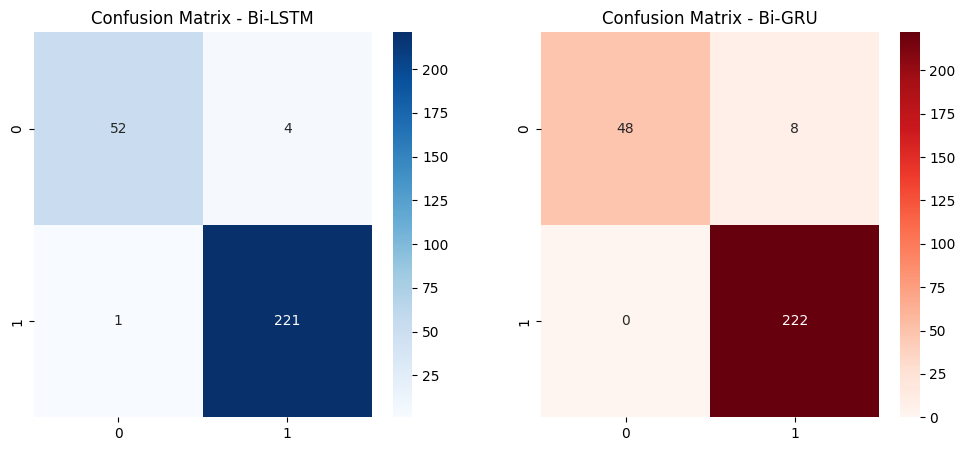

In [106]:
# Model Bi-LSTM
model_bilstm2 = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(best_unit)),
    Dropout(best_dropout),
    Dense(1, activation='sigmoid')
])

optimizer = get_optimizer(best_optimizer, learning_rate=best_lr)
model_bilstm2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("Model Bi-LSTM Dibuat")

history_bilstm2 = model_bilstm2.fit(X_train_pad, y_train_resampled, epochs=10, validation_data=(X_test_pad, y_test), batch_size=best_batch, verbose=0)

# Model Bi-GRU
model_bigru2 = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(GRU(best_unit)),
    Dropout(best_dropout),
    Dense(1, activation='sigmoid')
])

optimizer = get_optimizer(best_optimizer, learning_rate=best_lr)
model_bigru2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("Model Bi-GRU Dibuat")
history_bigru2 = model_bigru2.fit(X_train_pad, y_train_resampled, epochs=10, validation_data=(X_test_pad, y_test), batch_size=best_batch, verbose=0)

# Evaluasi Model
y_pred_bilstm2 = (model_bilstm2.predict(X_test_pad) > 0.5).astype("int32").flatten()
y_pred_bigru2 = (model_bigru2.predict(X_test_pad) > 0.5).astype("int32").flatten()

print("Evaluasi Bi-LSTM:")
print(classification_report(y_test, y_pred_bilstm2, digits=4))
print("Evaluasi Bi-GRU:")
print(classification_report(y_test, y_pred_bigru2, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm2), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Bi-LSTM")
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_bigru2), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Bi-GRU")
plt.show()

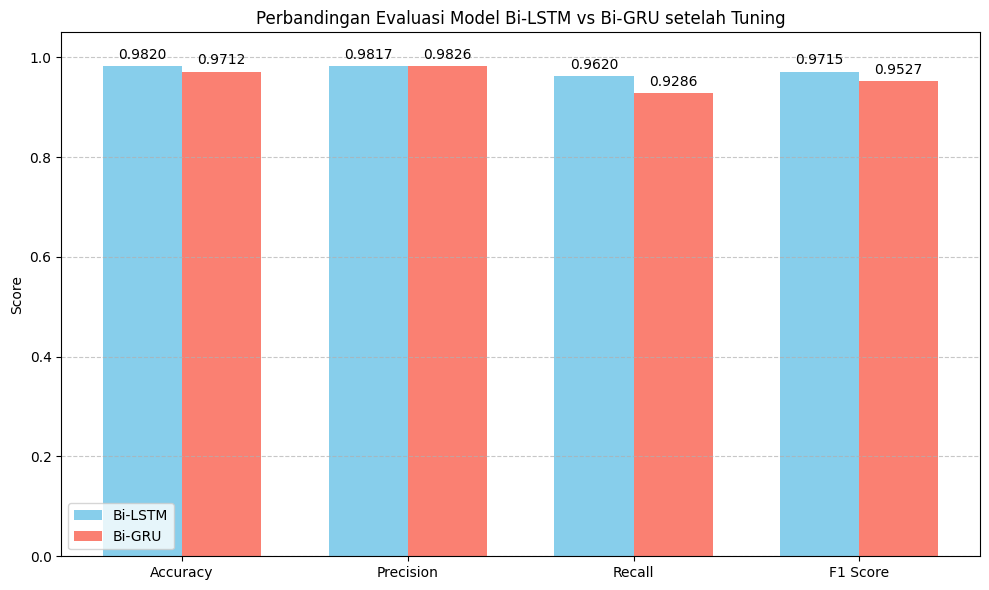

In [107]:
# Hitung metrik untuk Bi-LSTM
acc_bilstm2 = accuracy_score(y_test, y_pred_bilstm2)
prec_bilstm2 = precision_score(y_test, y_pred_bilstm2, average='macro')
rec_bilstm2 = recall_score(y_test, y_pred_bilstm2, average='macro')
f1_bilstm2 = f1_score(y_test, y_pred_bilstm2, average='macro')

# Hitung metrik untuk Bi-GRU
acc_bigru2 = accuracy_score(y_test, y_pred_bigru2)
prec_bigru2 = precision_score(y_test, y_pred_bigru2, average='macro')
rec_bigru2 = recall_score(y_test, y_pred_bigru2, average='macro')
f1_bigru2 = f1_score(y_test, y_pred_bigru2, average='macro')

# Simpan skor
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bilstm2_scores = [acc_bilstm2, prec_bilstm2, rec_bilstm2, f1_bilstm2]
bigru2_scores = [acc_bigru2, prec_bigru2, rec_bigru2, f1_bigru2]

# Plot bar chart
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, bilstm2_scores, width, label='Bi-LSTM', color='skyblue')
bars2 = ax.bar(x + width/2, bigru2_scores, width, label='Bi-GRU', color='salmon')

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score')
ax.set_ylim(0, 1.05)
ax.set_title('Perbandingan Evaluasi Model Bi-LSTM vs Bi-GRU setelah Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [109]:
print("=== KESIMPULAN PARAMETER TERBAIK UNTUK MODEL Bi-LSTM ===")
print(f"Dropout        : {best_dropout}")
print(f"Optimizer      : {best_optimizer} (learning rate = {best_lr})")
print(f"Batch Size     : {best_batch}")
print(f"Jumlah Unit    : {best_unit}")
print("\nModel akhir menggunakan kombinasi parameter terbaik di atas.")

=== KESIMPULAN PARAMETER TERBAIK UNTUK MODEL Bi-LSTM ===
Dropout        : 0.2
Optimizer      : Adam (learning rate = 0.005)
Batch Size     : 32
Jumlah Unit    : 32

Model akhir menggunakan kombinasi parameter terbaik di atas.


In [ ]:
#model_bilstm2.save('model_bilstm__best.keras')
#model_bigru2.save('model_bigru__best.keras')